In [ ]:
!pip install opendatasets -q

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: beantsran 
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:10<00:00, 59.2MB/s]


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_dir = "./gtsrb-german-traffic-sign"
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))
print("Dataset Loaded!", train_csv.shape)

Dataset Loaded! (39209, 8)


In [ ]:
# Prepare images and labels

X, y = [], []
image_size = (32, 32)

for i, row in train_csv.iterrows():
    img_path = os.path.join(data_dir, row['Path'])
    image = cv2.imread(img_path)
    if image is not None:
        image = cv2.resize(image, image_size)
        X.append(image)
        y.append(row['ClassId'])
    else:
        print(f"Warning: Could not read image at path: {img_path}")

In [ ]:
X = np.array(X) / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)   # It one-hot encodes class labels.

**Train-Test Split**

In [ ]:
# Train-test split

# Get the original class IDs (before one-hot encoding)
y_original_labels = np.argmax(y, axis=1)

# Find classes with only one sample
class_counts = pd.Series(y_original_labels).value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Filter out samples belonging to single-sample classes
mask = ~np.isin(y_original_labels, single_sample_classes)
X_filtered = X[mask]
y_filtered = y[mask]

# Perform train-test split on the filtered data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)
print("Data Split Done! Train Shape:", X_train.shape, "Test Shape:", X_test.shape)

Data Split Done! Train Shape: (27446, 32, 32, 3) Test Shape: (11763, 32, 32, 3)


In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.15, width_shift_range=0.1, height_shift_range=0.1)


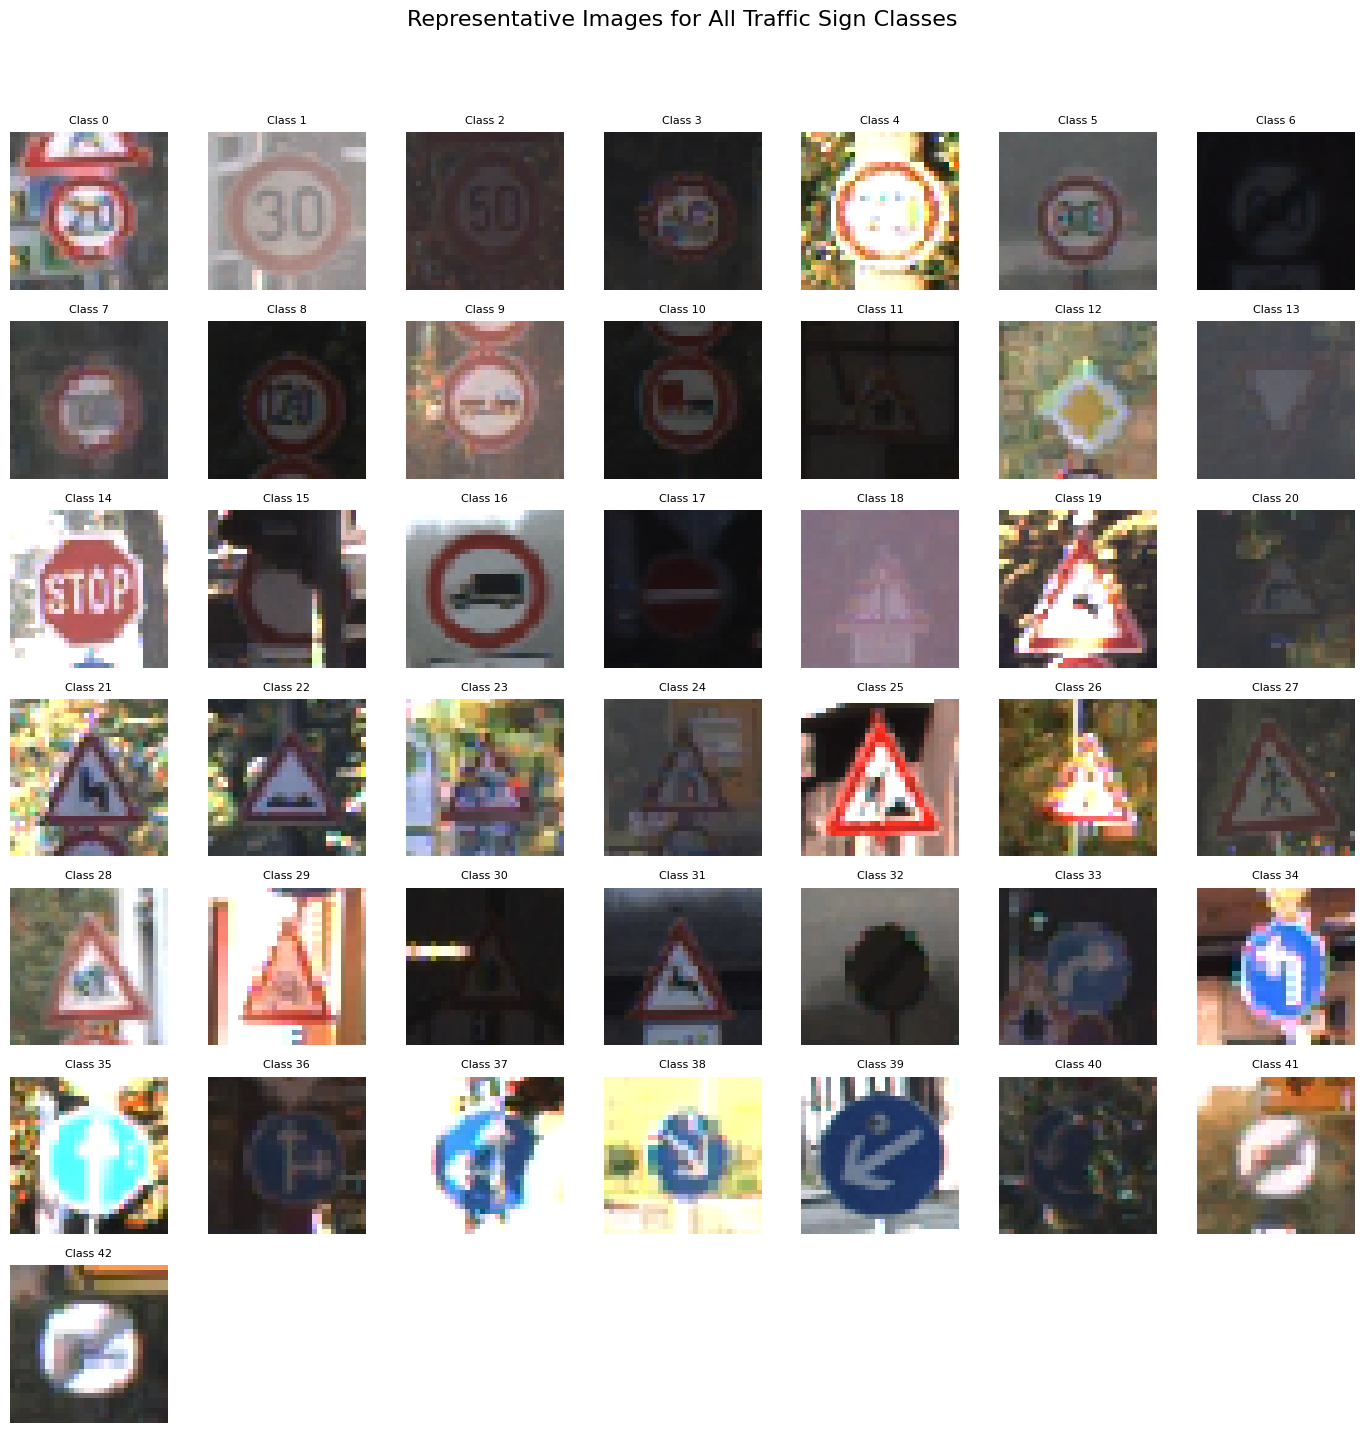

In [ ]:
# Visualizing all the different Signs
NUM_CATEGORIES = 43
IMG_WIDTH, IMG_HEIGHT = 32, 32

# Use the 'train_csv' DataFrame created earlier to find representative images
# Group by 'ClassId' and take the first image from each group
representative_images = train_csv.groupby('ClassId').first().reset_index()

plt.figure(figsize=(14, 14))
plt.suptitle("Representative Images for All Traffic Sign Classes", fontsize=16, y=1.02)

for i in range(NUM_CATEGORIES):
    # Find an image for the current class 'i'
    class_info = representative_images[representative_images['ClassId'] == i]
    if not class_info.empty:
        # Construct the full image path using the 'data_dir' variable
        relative_path_in_df = class_info.iloc[0]['Path'] # e.g., 'images/00000.jpg'
        full_img_path = os.path.join(data_dir, relative_path_in_df)

        try:
            img = load_img(full_img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))

            # Plotting
            plt.subplot(7, 7, i + 1)
            plt.imshow(img)
            plt.title(f'Class {i}', fontsize=8)
            plt.axis('off')
        except FileNotFoundError:
            print(f"Warning: Image file not found for Class {i} at {full_img_path}")
        except Exception as e:
            print(f"Error loading image for Class {i} at {full_img_path}: {e}")
    else:
        print(f"Warning: No images found in training data for Class {i}")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Model Architecture**

In [ ]:
# Building CNN Model
NUM_CLASSES = 43
INPUT_SHAPE = (32, 32, 3)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,211,851 (4.62 MB)

 Trainable params: 1,211,211 (4.62 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


**Training the Model**

In [ ]:
# Training Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=15)


Epoch 1/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 232s 265ms/step - accuracy: 0.2545 - loss: 2.9699 - val_accuracy: 0.7411 - val_loss: 0.7234
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 230s 268ms/step - accuracy: 0.6990 - loss: 0.8913 - val_accuracy: 0.9340 - val_loss: 0.1831
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 230s 268ms/step - accuracy: 0.8688 - loss: 0.4075 - val_accuracy: 0.9748 - val_loss: 0.0811
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 229s 267ms/step - accuracy: 0.9148 - loss: 0.2763 - val_accuracy: 0.9895 - val_loss: 0.0306
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 229s 267ms/step - accuracy: 0.9432 - loss: 0.1859 - val_accuracy: 0.9855 - val_loss: 0.0470
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 232s 270ms/step - accuracy: 0.9505 - loss: 0.1680 - val_accuracy: 0.9904 - val_loss: 0.0306
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 261s 269ms/step - accuracy: 0.9559 - loss: 0.1510 - val_accuracy: 0.9939 - val_loss: 0.0188
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 228s 265ms/step - accuracy: 0.9646 -

In [ ]:
# Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

368/368 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9944 - loss: 0.0160
Test Accuracy: 99.46%


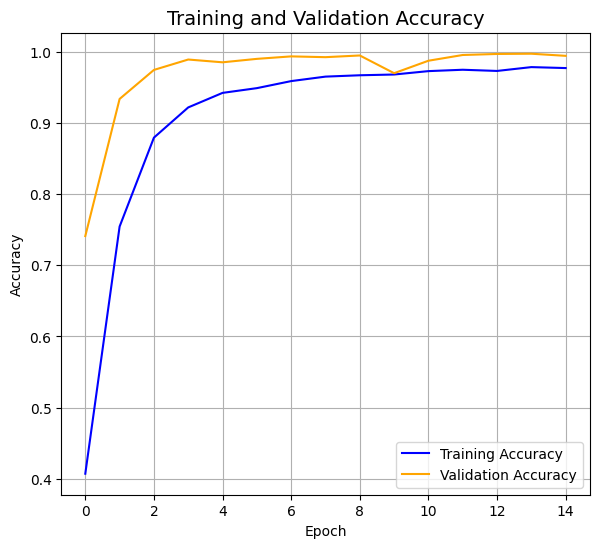

In [ ]:
# Plot Training History
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

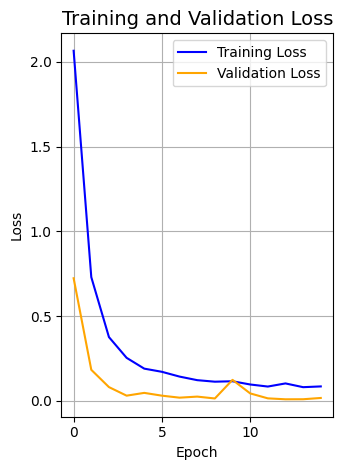

In [ ]:
#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


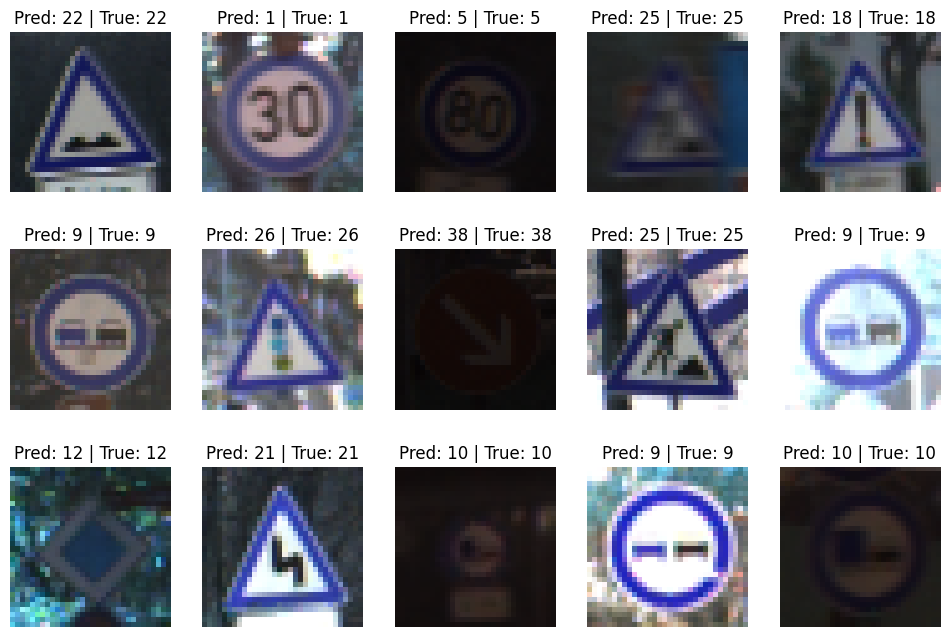

In [ ]:
# Predict Sample Images
def predict_sample_images():
    fig, axes = plt.subplots(3, 5 , figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        img = X_test[i]
        true_label = np.argmax(y_test[i])
        pred_label = np.argmax(model.predict(img.reshape(1, 32, 32, 3)))
        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label} | True: {true_label}")
        ax.axis('off')
    plt.show()

predict_sample_images()

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
             31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [ ]:
!pip install torch --q

In [ ]:
import tensorflow as tf
model.save("model.keras")

with open("model.keras", "rb") as f:
  print("Model file saved successfully",f.name)

Model file saved successfully model.keras
